#### CS166 Assignment 2 Code:

### N-Lane Traffic Flow Simulation

_Yoav Rabinovich, February 2019_

________________________________________

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
class TrafficSimulation:
    
    def __init__(self, l_road=100, n_lanes=1, density=0.18, v_max=5, p_slow=0.5, p_change=0.8, lookback=-1):
        self.l_road = l_road
        self.n_lanes = n_lanes
        self.density = density
        self.v_max = v_max
        self.p_slow = p_slow
        self.p_change = p_change
        self.lookback = lookback
        if self.lookback==-1:
            self.lookback=self.v_max
        self.init_state()
        
    def init_state(self):
        # Create base shape with empty tiles
        state = np.full((self.n_lanes, self.l_road), -1)
        # Initialize lanes
        for lane in range(self.n_lanes):
            # Amount of cars in lane
            n_cars = np.random.binomial(self.l_road,self.density)
            # Set stationary cars in random locations
            state[lane, np.random.choice(self.l_road, n_cars, False)] = 0
         
        self.state = state
        
    def switch(self):
        # Create a copy of state for syncronous updates
        new_state = self.state.copy()
        for lane in range(self.n_lanes):
            # Check for blocked cars in lane
            gaps = np.ediff1d(np.nonzero(self.state[lane]+1))
            gaps_periodic = np.concatenate((gaps, [self.l_road-sum(gaps)]))-1
            positions = np.nonzero(self.state[lane] != -1)[0]
            overtakers = positions[self.state[lane, positions] > gaps_periodic]
            # Check for clear other lane
            overtakers = [ot for ot in overtakers 
                          if (self.state[(lane+1)%self.n_lanes,
                                         np.arange(ot-self.lookback,
                                                   ot+self.state[lane,ot]+1)
                                         %self.l_road]
                              == -1)
                          .all()]
            # Cancel randomly
            chance = overtakers*(np.random.rand(1, len(overtakers)) < self.p_change)
            overtakers = chance[chance!=0].astype(int)
            # if len(overtakers)>0:print(overtakers)
            # Move cars in new state
            new_state[lane, overtakers] = np.full((1,len(overtakers)),-1)
            new_state[(lane+1)%self.n_lanes, overtakers] = self.state[lane,overtakers]
        # Update state
        self.state = new_state
            
    def accelerate(self):
        # For each car, if speed is lower than limit, increase it by 1
        self.state[(self.state < self.v_max) & (self.state > -1)] += 1
        
    def decelerate(self):
        # For each car, if speed is greater than empty road ahead,
        # set it to empty road length
        for lane in range(self.n_lanes):
            # Find the gaps between cars, considering periodic boundaries
            gaps = np.ediff1d(np.nonzero(self.state[lane]+1))
            gaps_periodic = np.concatenate((gaps, [self.l_road-sum(gaps)]))-1
            # Find car positions and clip their speeds to gap length if too fast
            positions = (lane, self.state[lane] != -1)
            self.state[positions] = np.clip(self.state[positions], a_min=0, a_max=gaps_periodic)
            
    def randomize(self):
        # For each car, if it's not stationary, probability p_slow to decelerate 1
        cars = len(self.state[self.state > 0])
        self.state[self.state > 0] -= np.random.choice([0, 1], cars, [1-self.p_slow, self.p_slow])
        
    def move(self):
        # Move each car according to it's velocity, considering periodic boundaries
        # Keep track of and return flow at boundary
        j = np.zeros(self.n_lanes)
        for lane in range(self.n_lanes):
            # Old positions
            pos_old = np.where(self.state[lane] > 0)
            # Velocities
            vels = self.state[lane, pos_old]
            # Deleting old cars
            self.state[lane, pos_old] = -1
            # New positions
            pos_new = pos_old + vels
            # Moving cars
            self.state[lane, pos_new % self.l_road] = vels
            # Flow is increased for each car that crosses the boundary
            j[lane] = np.sum(pos_new >= self.l_road)
        # Return flow
        return j
        
    def display(self):
        # Print state
        for lane in range(self.n_lanes):
            print("".join('.' if x == -1 else str(x) for x in self.state[lane]))
        if self.n_lanes>1: print("")
        
    def run(self, steps, display=False, warmup=0):
        # Run simulation for a given amount of steps
        # Optionally skip initial steps for flow count
        # Optionally print states
        # Return mean flow
        js = np.zeros((steps-warmup, self.n_lanes))
        # For each step, perform all substeps sequentially
        for step in range(steps):
            # Switch lanes
            self.switch()
            # Accelerate
            self.accelerate()
            # Decelerate
            self.decelerate()
            # Randomly Decelerate
            self.randomize()
            # Display
            if display:
                self.display()
            # Move cars and record flow
            j = self.move()
            # Record flow
            if step >= warmup:
                js[step-warmup] = j
        # Return mean flow
        return np.mean(js)

In [0]:
def plot_flows(simulator, densities, steps=100, runs=100, color="red", ax=None):
        
    trials = np.zeros((len(densities),runs))
    for index, value in enumerate(densities):
        simulator.density=value
        for run in range(runs):
            simulator.init_state()
            trials[index,run]=simulator.run(steps)
            
    line = np.mean(trials,axis=1)
    p_05 = np.percentile(trials,5,axis=1)
    p_95 = np.percentile(trials,95,axis=1)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.plot(densities,line,color=color)
    best_j = densities[np.argmax(line)]
    ax.axvline(x=best_j,color=color)
    ax.plot(densities,p_05,color=color,alpha=0.5)
    ax.plot(densities,p_95,color=color,alpha=0.5)
    
    for index,row in enumerate(trials):
        x = np.full((1,len(row)),densities[index])
        ax.scatter(x,row,color="blue")

    ax.set_xlabel('Density')
    ax.set_ylabel('Flow')
    plt.show()
    print("Optimal Density: " + str(best_j))
    print("Optimal Flow: " + str(np.max(line)) + " +/- " + str(np.std(trials[np.argmax(line)])))

In [0]:
def plot_flows_together(simulator, densities, steps=100, runs=100, color="red", ax=None):
        
    trials = np.zeros((len(densities),runs))
    for index, value in enumerate(densities):
        simulator.density=value
        for run in range(runs):
            simulator.init_state()
            trials[index,run]=simulator.run(steps)
            
    line = np.mean(trials,axis=1)
    p_05 = np.percentile(trials,5,axis=1)
    p_95 = np.percentile(trials,95,axis=1)
    
    ax.plot(densities,line,color=color)
    best_j = densities[np.argmax(line)]
    ax.axvline(x=best_j,color=color)

    ax.set_xlabel('Density')
    ax.set_ylabel('Flow')
    print("Optimal Density: " + str(best_j))
    print("Optimal Flow: " + str(np.max(line)) + " +/- " + str(np.std(trials[np.argmax(line)])))

In [0]:
sim = TrafficSimulation()
sim.run(50,True)

0.......0.1.0.1....0..001...0.....0..0...0....001....1......000...................1..0..1.0.....1...
1.......1..01..2...0..01.2..1.....0..0...1....01.2....2.....001....................1.1...01......2..
.1.......1.1.1...0.0..0.1..0.1....0..0....1...0.1..2....2...01.2....................1.1..0.1.......1
0.1.......0.1.2..1.1..1..1.0..2...0..1.....1..0..1...2....1.0.1..2...................0.0.1..2.......
0..2......0..1..0.0.1..1..01....0.0...1.....0.1...2....2...01..2...2.................0.1..2...3.....
0....2....1...1.0.0..2..0.1.1...1.0....1....1..1....3....1.1.1...3...3...............1..2...2....2..
0......2...1...00.0....00..1.2...01.....1....2..1......1..1.0.2.....2...3.............1...3...3....0
1........2..2..00.0....00...2..0.0.2.....1.....1.1......2..01...2.....3....3...........1.....2...0.0
.2.........1..001.1....01.....01.0...2....1.....0.2.......01.2....2......4....4.........1......1.1.0
...3........1.00.1.2...1.1....1.00.....3...1....1...2.....1.2..2....2........4....4......2.

0.32

In [0]:
sim5 = TrafficSimulation(n_lanes=5)
sim5.run(20,True)

..1............1...0..01..0.0.......0..00....1....0....1.00.............................1...........
....1..0..........0.......0.0...01.1.......0......1.......000.0......1...001.....1.....1....0..1.0..
..1.1.......0...0..........01....0......1........01...........0.0..........0.0..0.........01.1...0.1
..0...00......1.........1..0..0...0......1...1....1........0.......1..1...1.1.....01...0..0.........
......0.1....1...001.............0.......1........01..01...0...1..1...00....1......1................

...1............1..0..1.1.1.0.......0..00.....2...0.....000..............................1..........
.....0.1..........1.......0.0...0.0.1......1.......1......001.0.......1..00.1.....1.....1...1...01..
2..1.1......1...1..........0.1...1.......2.......0.2..........1.0..........1.0..0.........1.0.1..0..
..1...01.......2.........1.0..0...1.......2...2....2.......1........1..1...1.2....0.1..1..0.........
......1..2....2..00.1............1........2.......1.1.1.1..1....2..2..01.....1......1.....

0.28

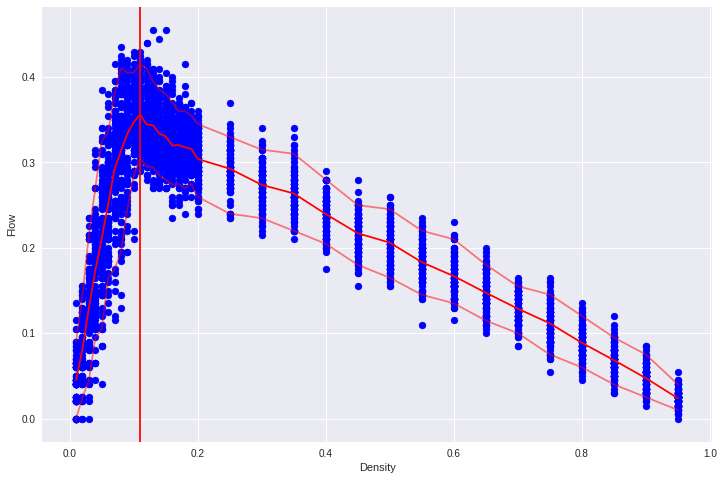

Optimal Density: 0.11
Optimal Flow: 0.35639999999999994 +/- 0.035079053579023474


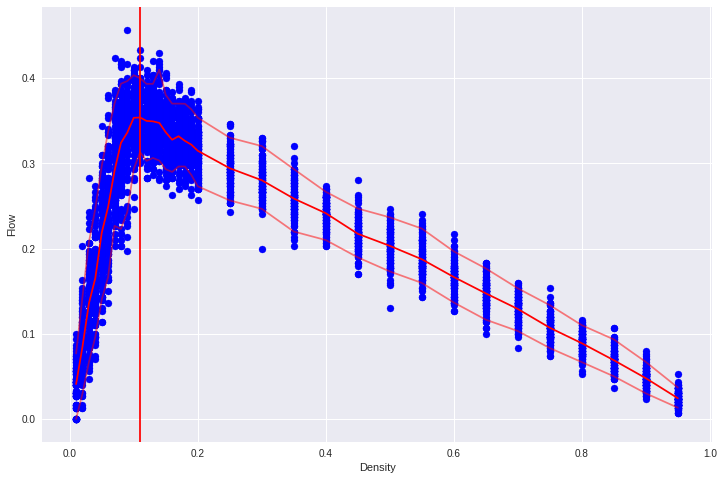

Optimal Density: 0.11
Optimal Flow: 0.3539 +/- 0.02736605764649178


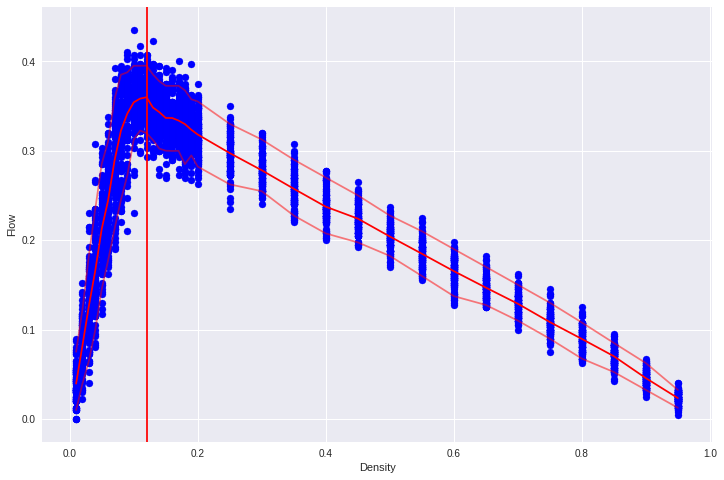

Optimal Density: 0.12
Optimal Flow: 0.359825 +/- 0.022823384389699965


In [0]:
sim2 = TrafficSimulation(n_lanes=2)
sim3 = TrafficSimulation(n_lanes=3)
sim4 = TrafficSimulation(n_lanes=4)
densities = np.concatenate([np.linspace(0.01,0.2,20),np.linspace(0.25,0.95,15)])
plot_flows(sim2,densities,100,100)
plot_flows(sim3,densities,100,100)
plot_flows(sim4,densities,100,100)

Optimal Density: 0.11
Optimal Flow: 0.34885000000000005 +/- 0.03864488970096822
Optimal Density: 0.11
Optimal Flow: 0.3508500000000001 +/- 0.04037359904690192
Optimal Density: 0.11
Optimal Flow: 0.35080000000000006 +/- 0.0384559488245967


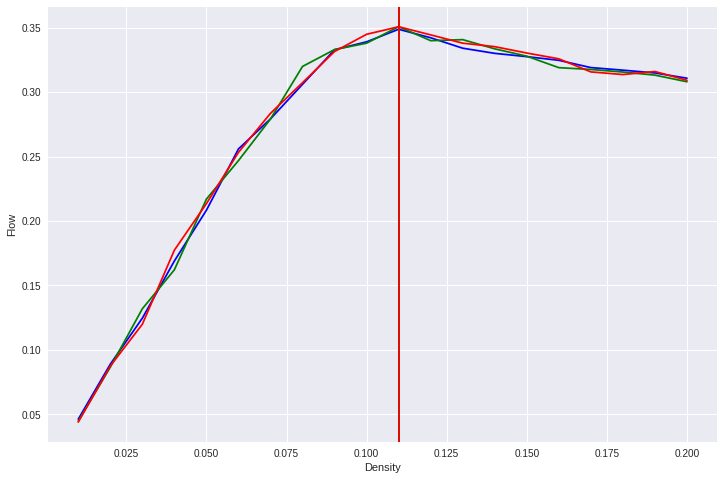

In [51]:
lb5 = TrafficSimulation(n_lanes=3)
lb2 = TrafficSimulation(n_lanes=3,lookback=2)
lb0 = TrafficSimulation(n_lanes=3,lookback=0)
fig, ax = plt.subplots(figsize=(12, 8))
densities2 = np.linspace(0.01,0.2,20)
plot_flows_together(sim2,densities2,100,100,"blue",ax)
plot_flows_together(sim2,densities2,100,100,"green",ax)
plot_flows_together(sim2,densities2,100,100,"red",ax)
plt.show()